# In what US City should you open a business and what type of business should it be?

#### In this project, we will analyze select US Cities to discover a lack of a certain type of business in one of the city to decide whether we should open a business of that type there or not.

#### The data used here are:
    + US Cities (first page (100 cities) of https://www.latlong.net/category/cities-236-15.html)
    + City Latitude and Longitude
    + Foursquare API's information which includes:
        - Venues in a raidus from a latitude and longitude
        - Venue Name
        - Venue Categories
    
#### The data will show us what venues are popular (by count) in each city and how many of them are around the latitude and longitude for each city. Using this data we can determine if a market for a specific business has room for growth or if there's too many of a specific business

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

print('Libraries imported.')

Libraries imported.


Create list of US Cities, split city and state

In [2]:
city_df = pd.read_html(r'https://www.latlong.net/category/cities-236-15.html')[0]

In [3]:
city_df.head()

,Place Name,Latitude,Longitude
0,"Hoboken, NJ, USA",40.745255,-74.034775
1,"Port Hueneme, CA, the US",34.155834,-119.202789
2,"Auburn, NY, USA",42.933334,-76.566666
3,"Jamestown, NY, the US",42.095554,-79.238609
4,"Fulton, MO, USA",38.846668,-91.948059


In [4]:
city_df['City'] = city_df['Place Name'].str.split(',', expand=True)[0]
city_df['State'] = city_df['Place Name'].str.split(',', expand=True)[1]
city_df = city_df[['City','State','Latitude','Longitude']]

Drop duplicate cities with same name

In [5]:
city_df = city_df.drop_duplicates('City')

In [6]:
city_df.sort_values(by='City').head(10)

,City,State,Latitude,Longitude
68,Amarillo,TX,35.199165,-101.845276
22,Antioch,CA,38.005001,-121.805832
73,Arlington,TX,32.705002,-97.122780
36,Athens,GA,33.950001,-83.383331
2,Auburn,NY,42.933334,-76.566666
65,Augusta,GA,33.466667,-81.966667
67,Aurora,IL,41.763889,-88.290001
78,Austin,TX,30.266666,-97.733330
5,Bedford,OH,41.392502,-81.534447
34,Berkeley,CA,37.871666,-122.272781


### Foursquare API Information

In [7]:
CLIENT_ID = 'WPVYKKSG3BEGIX5T3QFJOPTURIVR0FIT40RSZF0R42OMRCGE' # your Foursquare ID
CLIENT_SECRET = 'BQ5U2MDOBZ5D5VYXODXQCGDYLY0IIPOCN45LNOSLVLXPFCJQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

## Get venues for each city

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
city_venues = getNearbyVenues(names=city_df['City'],
                               latitudes=city_df['Latitude'],
                               longitudes=city_df['Longitude'])

print('getNearbyVenues Done')

Hoboken
Port Hueneme
Auburn
Jamestown
Fulton
Bedford
Stuart
San Angelo
Woodbridge
Vista
South Bend
Davenport
Sparks
Green Bay
San Mateo
Tyler
League City
Lewisville
Meridian
Waterbury
Jurupa Valley
West Palm Beach
Antioch
High Point
Miami Gardens
Murrieta
Springfield
El Monte
West Jordan
College Station
Fairfield
Evansville
Cambridge
Richardson
Berkeley
Columbia
Athens
Lafayette
Sterling Heights
Visalia
Hampton
West Valley City
Surprise
Thornton
Miramar
Murfreesboro
Pasadena
Bridgeport
Paterson
Rockford
Joliet
Escondido
Kansas City
Corona
Pembroke Pines
Elk Grove
Oceanside
Newport News
Sioux Falls
Vancouver
Worcester
Tallahassee
Columbus
Augusta
Montgomery
Aurora
Amarillo
Modesto
Garland
Irvine
Arlington
Memphis
Indianapolis
Austin
Dallas
Redwood City
Gastonia
New Braunfels
Palm Beach Gardens
Forestville
Houston
Muncie
Palm Springs
Hot Springs
Richmond
Fayetteville
Yuma
Peoria
Tempe
Diamond Bar
Hoover
Decatur
Bloomington
Utqiagvik
getNearbyVenues Done


In [10]:
# Createing back up to not run API if need a fresh data frame

city_backup = city_venues[:]
# city_venues = city_backup[:]

In [11]:
print(city_venues.shape)
city_venues.head()

(1519, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hoboken,40.745255,-74.034775,Work It Out-A Fitness Boutique,40.744356,-74.032567,Gym / Fitness Center
1,Hoboken,40.745255,-74.034775,Grand Vin,40.743209,-74.035099,Cocktail Bar
2,Hoboken,40.745255,-74.034775,Fiore's House of Quality,40.743019,-74.036183,Deli / Bodega
3,Hoboken,40.745255,-74.034775,Hudson River Athletics,40.745563,-74.032841,Gym / Fitness Center
4,Hoboken,40.745255,-74.034775,Dom's Bakery,40.743387,-74.034836,Bakery


## Check how many venues the API pulled for each city

In [12]:
city_venues[['City', 'Venue']].groupby('City').count()

,Venue
City,
Amarillo,7
Antioch,12
Arlington,12
Athens,11
Auburn,32
Augusta,5
Aurora,2
Austin,88
Bedford,10


In [13]:
# Check unique categories
print('There are {} unique categories'.format(city_venues['Venue Category'].nunique()))

There are 251 unique categories


## Let's encode the categories for each city and get weighted average

In [14]:
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")
city_onehot['City'] = city_venues['City'] 

fixed_columns = [city_onehot.columns[city_onehot.columns.get_loc('City')]] + list(city_onehot.loc[:, city_onehot.columns != 'City'].columns)
city_onehot = city_onehot[fixed_columns]

city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Residence Hall,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Courthouse,Credit Union,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Escape Room,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Optical Shop,Organic Grocery,Other Repair Shop,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Tourist Information Center,Toy / Game Store,Trade School,Trail,Train Station,Tree,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterans' Organization,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Amarillo,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.142857,0.0,0.0,0.285

## Get 10 Most Common Values for Each City

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##########################################################################

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_most = pd.DataFrame(columns=columns)
city_venues_most['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_most.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_most.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amarillo,Gas Station,Park,Lawyer,Furniture / Home Store,Liquor Store,American Restaurant,Farmers Market,Eye Doctor,Fabric Shop,Falafel Restaurant
1,Antioch,Fast Food Restaurant,Mexican Restaurant,Bank,Gym,Coffee Shop,Pharmacy,Grocery Store,Spa,Flower Shop,Filipino Restaurant
2,Arlington,Mexican Restaurant,Burger Joint,Pizza Place,Thrift / Vintage Store,Gym,Caribbean Restaurant,Donut Shop,Filipino Restaurant,Spa,Fish Market
3,Athens,Pizza Place,Fried Chicken Joint,College Residence Hall,BBQ Joint,Sandwich Place,Gas Station,Bookstore,Video Game Store,Pool,Wings Joint
4,Auburn,Pizza Place,Hotel,Italian Restaurant,Bar,Sandwich Place,Theater,Paper / Office Supplies Store,Brewery,Shipping Store,Cocktail Bar


## Get 10 Least Common Values for Each City

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##########################################################################

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
city_venues_least = pd.DataFrame(columns=columns)
city_venues_least['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_least.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_least.head()

,City,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Amarillo,ATM,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Optical Shop,Organic Grocery,Other Repair Shop
1,Antioch,ATM,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Optical Shop,Organic Grocery
2,Arlington,ATM,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Optical Shop
3,Athens,ATM,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub
4,Auburn,ATM,Motel,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Nightclub


In [17]:
city_most = city_venues_most.transpose()[:]
city_most.columns = list(city_most.iloc[0,:])
city_most = city_most.drop('City', axis=0).reset_index(drop=True)

In [18]:
city_most.reset_index(inplace=True)
city_most['place'] = city_most['index']+1

In [19]:
city_most.drop('index',axis=1,inplace=True)

In [20]:
city_most.head()

,Amarillo,Antioch,Arlington,Athens,Auburn,Augusta,Aurora,Austin,Bedford,Berkeley,Bloomington,Bridgeport,Cambridge,College Station,Columbia,Columbus,Corona,Dallas,Davenport,Decatur,Diamond Bar,El Monte,Elk Grove,Escondido,Evansville,Fairfield,Fayetteville,Forestville,Fulton,Garland,Gastonia,Green Bay,Hampton,High Point,Hoboken,Hoover,Hot Springs,Houston,Indianapolis,Irvine,Jamestown,Joliet,Jurupa Valley,Kansas City,League City,Lewisville,Memphis,Meridian,Miami Gardens,Miramar,Modesto,Montgomery,Muncie,Murfreesboro,Murrieta,New Braunfels,Newport News,Oceanside,Palm Beach Gardens,Palm Springs,Pasadena,Paterson,Pembroke Pines,Peoria,Port Hueneme,Redwood City,Richardson,Richmond,Rockford,San Angelo,San Mateo,Sioux Falls,South Bend,Sparks,Springfield,Sterling Heights,Stuart,Surprise,Tallahassee,Tempe,Thornton,Tyler,Utqiagvik,Vancouver,Visalia,Vista,Waterbury,West Jordan,West Palm Beach,Woodbridge,Worcester,Yuma,place
0,Gas Station,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Pizza Place,Brewery,Bus Stop,Food Truck,Bar,Sushi Restaurant,Construction & Landscaping,Juice Bar,Yoga Studio,American Restaurant,Pizza Place,Stables,Automotive Shop,History Museum,ATM,Diner,Fast Food Restaurant,Fast Food Restaurant,Bus Stop,American Restaurant,Gas Station,Clothing Store,Liquor Store,American Restaurant,Pizza Place,Park,Fast Food Restaurant,Bar,Gym,Coffee Shop,Gym,Grocery Store,Insurance Office,New American Restaurant,Dance Studio,Park,Pharmacy,American Restaurant,Shopping Mall,Intersection,IT Services,Hotel,Convenience Store,Other Repair Shop,Gas Station,Bank,Fast Food Restaurant,Bakery,Diner,Italian Restaurant,Fast Food Restaurant,Water Park,Museum,Construction & Landscaping,Cosmetics Shop,Mexican Restaurant,Mexican Restaurant,Fried Chicken Joint,Park,Fast Food Restaurant,Motel,Sandwich Place,Bank,Hotel,Home Service,Convenience Store,Bank,Pizza Place,Bar,Video Store,Bar,Fast Food Restaurant,Home Service,Tennis Court,Arts & Crafts Store,Pizza Place,Tailor Shop,Bar,Asian Restaurant,Trail,Construction & Landscaping,Bakery,American Restaurant,Fried Chicken Joint,Bus Station,Men's Store,American Restaurant,Fast Food Restaurant,1
1,Park,Mexican Restaurant,Burger Joint,Fried Chicken Joint,Hotel,General Entertainment,Baseball Stadium,Bar,Hot Dog Joint,Coffee Shop,Tree,Bakery,Art Museum,Pool,Coffee Shop,Speakeasy,Yoga Studio,Hotel,Sandwich Place,American Restaurant,Fried Chicken Joint,Mexican Restaurant,Yoga Studio,Cosmetics Shop,Dive Bar,Cosmetics Shop,Discount Store,Burger Joint,American Restaurant,Gas Station,Business Service,Hotel,Intersection,Diner,Gym / Fitness Center,Pizza Place,Wine Shop,Bar,Park,Bakery,Bar,Hot Dog Joint,Grocery Store,American Restaurant,Pub,Mexican Restaurant,Recreation Center,Fabric Shop,Yoga Studio,Yoga Studio,Chinese Restaurant,Rock Club,Liquor Store,Bar,Mexican Restaurant,Bakery,Airport Service,Fast Food Restaurant,Market,American Restaurant,Fast Food Restaurant,Pizza Place,Baseball Field,Theater,Marijuana Dispensary,Japanese Restaurant,Gym,Sandwich Place,Italian Restaurant,Liquor Store,Pizza Place,Mexican Restaurant,Theater,Mexican Restaurant,Sandwich Place,Ice Cream Shop,Hotel,Café,Intersection,Sandwich Place,Soccer Field,Café,Chinese Restaurant,Pizza Place,Carpet Store,Italian Restaurant,Pizza Place,Food,Hotel,Park,New American Restaurant,Pharmacy,2
2,Lawyer,Bank,Pizza Place,College Residence Hall,Italian Restaurant,Fast Food Restaurant,Yoga Studio,Music Venue,Automotive Shop,Pizza Place,Photography Studio,Brazilian Restaurant,Burger Joint,Playground,Bar,Scenic Lookout,Escape Room,Coffee Shop,Italian Restaurant,Fried Chicken Joint,Sandwich Place,Japanese Restaurant,Escape Room,Mexican Restaurant,Thrift / Vintage Store,Mobile Phone Shop,Mexican Restaurant,Bakery,Food & Drink Shop,French Restaurant,School,Plaza,Fish Market,Sandwich Place,Deli / Bodega,Salon / Barbershop,Flea Market,Coffee Shop,Southern / Soul Food Restaurant,Business Service,Hotel,Baseball Field,Pizza Place,Bar,Park,Taco Place,Music Venue,Yoga Stud

Looking at the top 10 most venues on each of the cities. Let's see which is the most popular of all the cities (most #1 spots)

In [21]:
df1 = pd.DataFrame({'venue':city_venues_most['1st Most Common Venue'], 'count':1})
df1 = df1.groupby('venue').sum().reset_index()
df1.columns = ['Venue', 'count']
df1 = df1.sort_values(by='count', ascending=False).reset_index(drop=True)
df1.head()

,Venue,count
0,Fast Food Restaurant,9
1,American Restaurant,6
2,Pizza Place,6
3,Bar,5
4,Mexican Restaurant,3


We see that Pizza Place is the most common amongst the most popular
Let's get the cities that Fast Food Restaurant is # 1

In [22]:
city_venues_most[city_venues_most['1st Most Common Venue'] == 'Fast Food Restaurant'].reset_index(drop=True)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Antioch,Fast Food Restaurant,Mexican Restaurant,Bank,Gym,Coffee Shop,Pharmacy,Grocery Store,Spa,Flower Shop,Filipino Restaurant
1,Diamond Bar,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Furniture / Home Store,American Restaurant,Convenience Store,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market
2,El Monte,Fast Food Restaurant,Mexican Restaurant,Japanese Restaurant,Dentist's Office,Rental Car Location,Dessert Shop,Chinese Restaurant,Sandwich Place,Paper / Office Supplies Store,Bank
3,Gastonia,Fast Food Restaurant,Business Service,School,Supermarket,American Restaurant,Cosmetics Shop,Discount Store,Japanese Restaurant,Video Store,Sandwich Place
4,Modesto,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Sandwich Place,Paintball Field,Mexican Restaurant,Spa,Smoke Shop,Music Store,Thrift / Vintage Store
5,Murrieta,Fast Food Restaurant,Mexican Restaurant,Bank,Convenience Store,Big Box Store,Chinese Restaurant,Sushi Restaurant,Sandwich Place,Gift Shop,Fried Chicken Joint
6,Peoria,Fast Food Restaurant,Theater,Home Service,Bar,Clothing Store,Chinese Restaurant,Convenience Store,Automotive Shop,Business Service,Breakfast Spot
7,Sterling Heights,Fast Food Restaurant,Ice Cream Shop,Hardware Store,Pizza Place,Pharmacy,Mediterranean Restaurant,Gift Shop,Thrift / Vintage Store,Department Store,Intersection
8,Yuma,Fast Food Restaurant,Pharmacy,Shoe Store,Bank,Grocery Store,Donut Shop,Sandwich Place,Shipping Store,Dance Studio,Breakfast Spot


Now lets get the cities that has Pizza Place in the # 10 spot of the most popular

In [23]:
city_venues_most[city_venues_most['10th Most Common Venue'] == 'Fast Food Restaurant'].reset_index(drop=True)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,College Station,American Restaurant,Pool,Playground,Yoga Studio,Filipino Restaurant,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
1,Elk Grove,Bus Stop,Yoga Studio,Escape Room,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant
2,Garland,Park,Gas Station,French Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant
3,Kansas City,Intersection,American Restaurant,Bar,Yoga Studio,Filipino Restaurant,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
4,Miami Gardens,Gas Station,Yoga Studio,Escape Room,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant
5,Montgomery,Bakery,Rock Club,Women's Store,Smoke Shop,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
6,Newport News,Museum,Airport Service,American Restaurant,Gift Shop,Yoga Studio,Filipino Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
7,Thornton,Tailor Shop,Soccer Field,Yoga Studio,Food Truck,Food,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant
8,Vancouver,Trail,Pizza Place,Pharmacy,Convenience Store,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant


## We'll cluster the cities to see if any of the above are in the same cluster

In [26]:
kclusters = 6
city_grouped_clustering = city_grouped.drop('City', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)
kmeans.labels_

array([5, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       2, 0, 5, 0, 0, 0, 0, 5, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       5, 0, 0, 0, 5, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0])

In [27]:
city_venues_most.insert(0, 'Cluster Labels', kmeans.labels_)
city_merge = city_df
city_merge = city_df.join(city_venues_most.set_index('City'), on='City')
city_merge.head() # check the last columns!

,City,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hoboken,NJ,40.745255,-74.034775,0.0,Gym,Gym / Fitness Center,Deli / Bodega,Bakery,Pub,Park,Italian Restaurant,Pizza Place,Bar,Cocktail Bar
1,Port Hueneme,CA,34.155834,-119.202789,0.0,Motel,Marijuana Dispensary,Electronics Store,Dive Bar,Food,Flower Shop,Flea Market,Fish Market,Event Space,Filipino Restaurant
2,Auburn,NY,42.933334,-76.566666,0.0,Pizza Place,Hotel,Italian Restaurant,Bar,Sandwich Place,Theater,Paper / Office Supplies Store,Brewery,Shipping Store,Cocktail Bar
3,Jamestown,NY,42.095554,-79.238609,0.0,Pharmacy,Bar,Hotel,Museum,Video Store,Gym,Café,Mexican Restaurant,Sporting Goods Shop,Big Box Store
4,Fulton,MO,38.846668,-91.948059,0.0,Pizza Place,American Restaurant,Food & Drink Shop,Café,Burger Joint,Department Store,Baseball Field,Chinese Restaurant,Grocery Store,Shipping Store


### Drop Cities not in clusters

In [28]:
city_merge.dropna(inplace=True)

In [50]:
latitude = city_merge['Latitude'].mean()
longitude = city_merge['Longitude'].mean()

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merge['Latitude'], city_merge['Longitude'], city_merge['City'], city_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

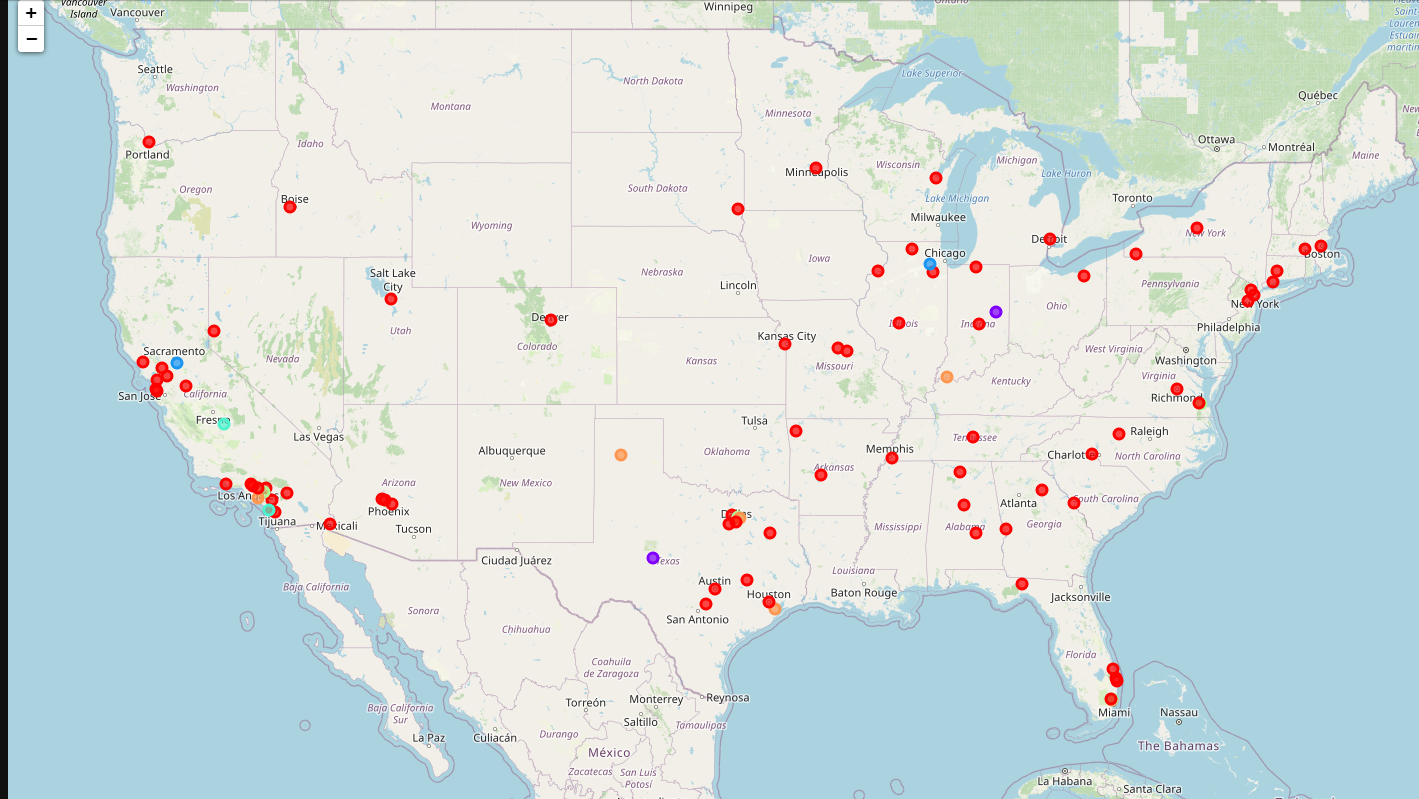

In [51]:
from IPython import display
display.Image(r'C:/Users/eadame/Documents/Learning/IBM Data Science Cert/Capstone Project/map_screenshot_2Capstone.png')

Cities with Pizza in # 1

In [31]:
list(city_venues_most[city_venues_most['1st Most Common Venue'] == 'Fast Food Restaurant'].reset_index(drop=True)['City'])

['Antioch',
 'Diamond Bar',
 'El Monte',
 'Gastonia',
 'Modesto',
 'Murrieta',
 'Peoria',
 'Sterling Heights',
 'Yuma']

Cities with Pizza in # 10

In [32]:
list(city_venues_most[city_venues_most['10th Most Common Venue'] == 'Fast Food Restaurant'].reset_index(drop=True)['City'])

['College Station',
 'Elk Grove',
 'Garland',
 'Kansas City',
 'Miami Gardens',
 'Montgomery',
 'Newport News',
 'Thornton',
 'Vancouver']

### Let's get clusters for the cities above

In [35]:
possible_cities = city_merge[(city_merge['City'].isin(
    list(city_venues_most[city_venues_most['1st Most Common Venue'] == 'Fast Food Restaurant'].
         reset_index(drop=True)['City'])))
           |
           (city_merge['City'].isin(
               list(city_venues_most[city_venues_most['10th Most Common Venue'] == 'Fast Food Restaurant'].
                    reset_index(drop=True)['City'])))]

possible_cities.head()

,City,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Antioch,CA,38.005001,-121.805832,0.0,Fast Food Restaurant,Mexican Restaurant,Bank,Gym,Coffee Shop,Pharmacy,Grocery Store,Spa,Flower Shop,Filipino Restaurant
24,Miami Gardens,FL,25.942122,-80.269920,5.0,Gas Station,Yoga Studio,Escape Room,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant
25,Murrieta,CA,33.569443,-117.202499,0.0,Fast Food Restaurant,Mexican Restaurant,Bank,Convenience Store,Big Box Store,Chinese Restaurant,Sushi Restaurant,Sandwich Place,Gift Shop,Fried Chicken Joint
27,El Monte,CA,34.073334,-118.027496,0.0,Fast Food Restaurant,Mexican Restaurant,Japanese Restaurant,Dentist's Office,Rental Car Location,Dessert Shop,Chinese Restaurant,Sandwich Place,Paper / Office Supplies Store,Bank
29,College Station,TX,30.601389,-96.314445,0.0,American Restaurant,Pool,Playground,Yoga Studio,Filipino Restaurant,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant


#### Get count of cities in cluster where Fast Food Restaurant is # 1

In [38]:
possible_cities[possible_cities['1st Most Common Venue'] == 'Fast Food Restaurant'][['Cluster Labels','City']].groupby('Cluster Labels').count()

,City
Cluster Labels,
0.0,9


#### Get count of cities in cluster where Fast Food Restaurant is # 10

In [39]:
possible_cities[possible_cities['10th Most Common Venue'] == 'Fast Food Restaurant'][['Cluster Labels','City']].groupby('Cluster Labels').count()

,City
Cluster Labels,
0.0,6
2.0,1
5.0,2


### We see that Cluster 0 has all the cities with Fast Food Restaurant being # 1, and there are 6 cities in Cluster 0 where Fast Food is # 10. This shows that there is growth opportunity for Fast Food since they are similar cities and the other ones have it at # 1

#### Let's see what those 6 cities are

In [48]:
possible_cities[(possible_cities['10th Most Common Venue'] == 'Fast Food Restaurant') & (possible_cities['Cluster Labels'] == 0)][['City', 'State']]

,City,State
29,College Station,TX
43,Thornton,CO
52,Kansas City,KS
59,Newport News,VA
61,Vancouver,WA
66,Montgomery,AL
